In [44]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

In [45]:

# define global variables
SPEED_OF_LIGHT = 299792458
ELEMENTARY_CHARGE = 1.602e-19
EARTH_RADIUS = 6.370 * (1e6)
RAD_PER_DEG = np.pi / 180.
KG_PER_GEVC2 = 1.78e-27
KGMS_PER_GEVC = 5.34e-19

KEY_LIST = ["t", "r", "theta", "phi", "pr", "ptheta", "pphi"]

# define the spherical components of Earth magnetic field
G10 = -29404.8 * (1e-9)# value of B-field at center of Earth
# G10 = -31221.6 * (1e-9)

In [46]:
# convert between coordinates defined in detector frame with geocentric coordinates
def detector_to_geocentric(lat, lng, detector_alt, zenith, azimuth,
                           particle_alt, momentum):

    # first convert angles (latitude, longitude, zenith, azimuth)
    # to radians
    lat *= RAD_PER_DEG
    lng *= RAD_PER_DEG
    zenith *= RAD_PER_DEG
    azimuth *= RAD_PER_DEG

    # now convert the coordinates / momentum
    # this can realistically be done in one step by utilizing matrix multiplication
    # with transformation matrices between cartesian, geodesic, and spherical

    # convert detector latitude, longitude, altitude into cartesian
    detector_x = (detector_alt + EARTH_RADIUS) * np.cos(lat) * np.cos(lng)
    detector_y = (detector_alt + EARTH_RADIUS) * np.cos(lat) * np.sin(lng)
    detector_z = (detector_alt + EARTH_RADIUS) * np.sin(lat)

    detector_geoc_coord = np.array([detector_x, detector_y, detector_z])

    # convert zenith, azimuth, and particle altitude to cartesian in detector frame
    particle_detector_x = (particle_alt +
                           EARTH_RADIUS) * np.sin(zenith) * np.cos(azimuth)
    particle_detector_y = (particle_alt +
                           EARTH_RADIUS) * np.sin(zenith) * np.sin(azimuth)
    particle_detector_z = (particle_alt + EARTH_RADIUS) * np.cos(zenith)

    particle_detector_coord = np.array(
        [particle_detector_x, particle_detector_y, particle_detector_z])

    # the transformation matrix between detector frame and geodesic coordinates
    row1 = np.array(
        [-np.sin(lng), -np.cos(lng) * np.sin(lat),
         np.cos(lat) * np.cos(lng)])
    row2 = np.array(
        [np.cos(lng), -np.sin(lat) * np.sin(lng),
         np.cos(lat) * np.sin(lng)])
    row3 = np.array([0., np.cos(lat), np.sin(lat)])

    transform_matrix = np.array([row1, row2, row3])
    
    print(transform_matrix)

    # now get the transformed coordinate vector in geocentric frame
    (particle_geoc_x,
     particle_geoc_y, particle_geoc_z) = detector_geoc_coord + np.dot(
         transform_matrix, particle_detector_coord)

    particle_r = np.sqrt(particle_geoc_x**2. + particle_geoc_y**2. +
                         particle_geoc_z**2.)
    particle_theta = np.arccos(particle_geoc_z / particle_r)
    particle_phi = np.arctan2(particle_geoc_y, particle_geoc_x)

    # now for momentum
    # convert the direction of the momentum of the particle (defined by zenith and azimuth angles)
    # with the magnitude of the momentum (obtained by energy / rigidity)
    particle_detector_px = momentum * np.sin(zenith) * np.cos(azimuth)
    particle_detector_py = momentum * np.sin(zenith) * np.sin(azimuth)
    particle_detector_pz = momentum * np.cos(zenith)

    particle_detector_momentum = np.array(
        [particle_detector_px, particle_detector_py, particle_detector_pz])
    
    print(particle_detector_momentum)

    # now transform the momentum vector into geocentric frame
    (particle_geoc_px, particle_geoc_py,
     particle_geoc_pz) = np.dot(transform_matrix, particle_detector_momentum)
    
    print(particle_geoc_px, particle_geoc_py,
     particle_geoc_pz)

    # here we should have conversion between cartesian and spherical again
    # but for momenta its more complicated
    # double check if this is actually correct (like the /r , /rsin(theta) parts)
    #  -> this is fixed, it should be removed to keep units consistent
    particle_pr = particle_geoc_px * np.sin(particle_theta) * np.cos(particle_phi) + \
            particle_geoc_py * np.sin(particle_theta) * np.sin(particle_phi) + \
            particle_geoc_pz * np.cos(particle_theta)
    
    particle_ptheta = (
        particle_geoc_px * np.cos(particle_theta) * np.cos(particle_phi) +
        particle_geoc_py * np.cos(particle_theta) * np.sin(particle_phi) -
        particle_geoc_pz * np.sin(particle_theta))
    particle_pphi = (-particle_geoc_px * np.sin(particle_phi) +
                     particle_geoc_py * np.cos(particle_phi))
    
    particle_sixvector = np.array([
        particle_r, particle_theta, particle_phi, particle_pr, particle_ptheta,
        particle_pphi
    ])

    return particle_sixvector

In [192]:
def Br(r, theta, phi):
    return ((2. * EARTH_RADIUS**3. * G10 * np.cos(theta)) / r**3.)
#     return 0.

def Btheta(r, theta, phi):
    return ((EARTH_RADIUS**3. * G10 * np.sin(theta)) / r**3.)
#     return G10


def Bphi(r, theta, phi):
    return 0.


In [213]:
# ODEs in spherical coordinates,
# based on lorentz force and the form of
# acceleration in spherical coordinates
def drdt(pr):
    return pr


def dthetadt(r, ptheta):
    return ptheta / r


def dphidt(r, theta, pphi):
    # dphi_dt = 0.0 if abs(theta) < 1e-12 else pphi / (r * np.sin(theta))
    return pphi / (r * np.sin(theta))


def dprdt(charge, r, theta, phi, pr, ptheta, pphi):
    lorentz_term = -charge * ((ptheta * Bphi(r, theta, phi)) - (pphi * Btheta(r, theta, phi)))
    auxiliary_terms = (ptheta**2. / r) + (pphi**2. / r)
    return lorentz_term + auxiliary_terms


def dpthetadt(charge, r, theta, phi, pr, ptheta, pphi):
    lorentz_term = charge * ((pr * Bphi(r, theta, phi)) - (pphi * Br(r, theta, phi)))
    auxiliary_terms = ((pphi**2. * np.cos(theta)) / (r * np.sin(theta))) - ((pr * ptheta) / r)
    return lorentz_term + auxiliary_terms


def dpphidt(charge, r, theta, phi, pr, ptheta, pphi):
    lorentz_term = -charge * ((pr * Btheta(r, theta, phi)) - (ptheta * Br(r, theta, phi)))
    auxiliary_terms = ((pr * pphi) / r) + ((ptheta * pphi * np.cos(theta)) /
                                           (r * np.sin(theta)))
    return lorentz_term - auxiliary_terms

In [215]:
# perform the Runge kutta sequence
def perform_runge_kutta(mass, charge, t0, initial_sixvec, dt, max_iter):
    # define array to append to
    # t_arr = np.zeros(max_iter)
    # r_arr = np.zeros(max_iter)
    # theta_arr = np.zeros(max_iter)
    # phi_arr = np.zeros(max_iter)
    # pr_arr = np.zeros(max_iter)
    # ptheta_arr = np.zeros(max_iter)
    # pphi_arr = np.zeros(max_iter)

    traj_dict = {key: [] for key in KEY_LIST}
    traj_dict["gamma"] = []
    traj_dict["p"] = []

    # define the initial values
    t = t0
    r = initial_sixvec[0]
    theta = initial_sixvec[1]
    phi = initial_sixvec[2]
    pr = initial_sixvec[3]
    ptheta = initial_sixvec[4]
    pphi = initial_sixvec[5]
    
    

    # get the relativistic mass (mass * lorentz factor)
    # to do this we get magnitude of momentum
    # since no acceleration should occur, lorentz factor will
    # remain constant, so it can be defined here
#     p = np.sqrt(pr**2. + (r * ptheta)**2. + (r * np.sin(theta) * pphi)**2.)
#     print(p)
#     p = np.sqrt(pr**2. + (ptheta)**2. + (pphi)**2.)
#     # print(mass * SPEED_OF_LIGHT)
#     gamma = np.sqrt(1. + (p / (mass * (SPEED_OF_LIGHT)))**2.)

#     print("Lorentz factor: {:.10e}\n".format(gamma))
#     rel_mass = mass * gamma
    
#     print(Btheta(r, theta, phi))

    # perform the integration process
    for i in range(max_iter):
        # first append the values to the array
        traj_dict["t"].append(t)
        traj_dict["r"].append(r)
        traj_dict["theta"].append(theta)
        traj_dict["phi"].append(phi)
        traj_dict["pr"].append(pr)
        traj_dict["ptheta"].append(ptheta)
        traj_dict["pphi"].append(pphi)
        
        p = np.sqrt(pr**2. + (ptheta)**2. + (pphi)**2.)
#         p = np.sqrt(pr**2. + (r * ptheta)**2. + (r * np.sin(theta) * pphi)**2.)
    
        traj_dict["p"].append(p)
        
#         gamma = (np.sqrt((p*SPEED_OF_LIGHT)**2. + (mass * SPEED_OF_LIGHT**2.)**2.) + mass) / mass
        
        gamma = np.sqrt(1. + (p / (mass * SPEED_OF_LIGHT))**2.) + 1
#         gamma = 11.7

#         print("Lorentz factor: {:.10e}\n".format(gamma))
        rel_mass = mass * gamma
    
        traj_dict["gamma"].append(gamma)
        
        # perform runge kutta steps

        # first runge kutta variable
        r_k1 = dt * drdt(pr)
        theta_k1 = dt * dthetadt(r, ptheta)
        phi_k1 = dt * dphidt(r, theta, pphi)
        pr_k1 = dt * dprdt(charge, r, theta, phi, pr, ptheta, pphi)
        ptheta_k1 = dt * dpthetadt(charge, r, theta, phi, pr, ptheta, pphi)
        pphi_k1 = dt * dpphidt(charge, r, theta, phi, pr, ptheta, pphi)

        # second runge kutta variable
        r_k2 = dt * drdt(pr + (0.5 * pr_k1))
        theta_k2 = dt * dthetadt(r + (0.5 * r_k1), ptheta + (0.5 * ptheta_k1))
        phi_k2 = dt * dphidt(r +( 0.5 * r_k1), theta + (0.5 * theta_k1),
                             pphi + (0.5 * pphi_k1))
        pr_k2 = dt * dprdt(charge, r + (0.5 * r_k1), theta + (0.5 * theta_k1),
                           phi + (0.5 * phi_k1), pr + (0.5 * pr_k1),
                           ptheta + (0.5 * ptheta_k1), pphi + (0.5 * pphi_k1))
        ptheta_k2 = dt * dpthetadt(
            charge, r + (0.5 * r_k1), theta + (0.5 * theta_k1), phi +( 0.5 * phi_k1),
            pr + (0.5 * pr_k1), ptheta + (0.5 * ptheta_k1), pphi + (0.5 * pphi_k1))
        pphi_k2 = dt * dpphidt(charge, r + (0.5 * r_k1), theta + (0.5 * theta_k1),
                               phi + (0.5 * phi_k1), pr + (0.5 * pr_k1),
                               ptheta + (0.5 * ptheta_k1), pphi + (0.5 * pphi_k1))

        # third runge kutta variable
        r_k3 = dt * drdt(pr + (0.5 * pr_k2))
        theta_k3 = dt * dthetadt(r + (0.5 * r_k2), ptheta +( 0.5 * ptheta_k2))
        phi_k3 = dt * dphidt(r + (0.5 * r_k2), theta + (0.5 * theta_k2),
                             pphi + (0.5 * pphi_k2))
        pr_k3 = dt * dprdt(charge, r + (0.5 * r_k2), theta + (0.5 * theta_k2),
                           phi + (0.5 * phi_k2), pr + (0.5 * pr_k2),
                           ptheta + (0.5 * ptheta_k2), pphi +( 0.5 * pphi_k2))
        ptheta_k3 = dt * dpthetadt(
            charge, r + (0.5 * r_k2), theta + (0.5 * theta_k2), phi + (0.5 * phi_k2),
            pr + (0.5 * pr_k2), ptheta +( 0.5 * ptheta_k2), pphi + (0.5 * pphi_k2))
        pphi_k3 = dt * dpphidt(charge, r +( 0.5 * r_k2), theta + (0.5 * theta_k2),
                               phi + (0.5 * phi_k2), pr + (0.5 * pr_k2),
                               ptheta + (0.5 * ptheta_k2), pphi + (0.5 * pphi_k2))

        # forth runge kutta variable
        r_k4 = dt * drdt(pr + pr_k3)
        theta_k4 = dt * dthetadt(r + r_k3, ptheta + ptheta_k3)
        phi_k4 = dt * dphidt(r + r_k3, theta + theta_k3, pphi + pphi_k3)
        pr_k4 = dt * dprdt(charge, r + r_k3, theta + theta_k3, phi + phi_k3,
                           pr + pr_k3, ptheta + ptheta_k3, pphi + pphi_k3)
        ptheta_k4 = dt * dpthetadt(charge, r + r_k3, theta + theta_k3,
                                   phi + phi_k3, pr + pr_k3,
                                   ptheta + ptheta_k3, pphi + pphi_k3)
        pphi_k4 = dt * dpphidt(charge, r + r_k3, theta + theta_k3,
                               phi + phi_k3, pr + pr_k3, ptheta + ptheta_k3,
                               pphi + pphi_k3)

        # finally get the weighted sum of them
        r_k = (1. / (6. * rel_mass)) * (r_k1 + (2. * r_k2) + (2. * r_k3) + r_k4)
        theta_k = (1. / (6. * rel_mass)) * (theta_k1 +( 2. * theta_k2) +
                                            (2. * theta_k3) + theta_k4)
        phi_k = (1. / (6. * rel_mass)) * (phi_k1 + (2. * phi_k2) + (2. * phi_k3) +
                                          phi_k4)
        pr_k = (1. /
                (6. * rel_mass)) * (pr_k1 + (2. * pr_k2) + (2. * pr_k3) + pr_k4)
        ptheta_k = (1. / (6. * rel_mass)) * (ptheta_k1 + (2. * ptheta_k2) +
                                             (2. * ptheta_k3) + ptheta_k4)
        pphi_k = (1. / (6. * rel_mass)) * (pphi_k1 + (2. * pphi_k2) +
                                           (2. * pphi_k3) + pphi_k4)

        # increment by weighted sums (and stepsize for time)
        r += r_k
        theta += theta_k
        phi += phi_k
        pr += pr_k
        ptheta += ptheta_k
        pphi += pphi_k
        t += dt

#         r_euler = dt * drdt(pr) / rel_mass
#         theta_euler = dt * dthetadt(r, ptheta) / rel_mass
#         phi_euler = dt * dphidt(r, theta, pphi) / rel_mass
#         pr_euler = dt * dprdt(charge, r, theta, phi, pr, ptheta, pphi) / rel_mass
#         ptheta_euler = dt * dpthetadt(charge, r, theta, phi, pr, ptheta, pphi) / rel_mass
#         pphi_euler = dt * dpphidt(charge, r, theta, phi, pr, ptheta, pphi) / rel_mass
        
        
        
#         r += r_euler
#         theta += theta_euler
#         phi += phi_euler
#         pr += pr_euler
#         ptheta += ptheta_euler
#         pphi += pphi_euler
#         t += dt
        
        
        # euler steps below
#         pr += dt * dprdt(charge, r, theta, phi, pr, ptheta, pphi)
#         ptheta += dt * dpthetadt(charge, r, theta, phi, pr, ptheta, pphi)
#         pphi += dt * dpphidt(charge, r, theta, phi, pr, ptheta, pphi)
#         r = r + dt * drdt(pr)
#         theta = theta + dt * dthetadt(r, ptheta)
#         phi += dt * dphidt(r, theta, pphi)
        
        
#         if i % (max_iter // 10) == 0:
#             print(dphidt(r, theta, pphi), dpphidt(charge, r, theta, phi, pr, ptheta, pphi))
#             print(r)
#             print(theta)
#             print(phi)
#             print(pr)
#             print(ptheta)
#             print(pphi)
#             print('\n')


#             p = np.sqrt(pr**2. + (ptheta)**2. + (pphi)**2.)
#             print(p / KGMS_PER_GEVC )
#             print(np.sqrt(1. + (p / (mass * SPEED_OF_LIGHT))**2.))
#             print(Btheta(r, theta, phi))
#             print('\n')
        #         print(ptheta / r)
        #         print(pphi)
        #         print(p)

        # now check conditions for breaking the loop
        # if particle has effectively escaped
        if r > 10 * EARTH_RADIUS:
            print("Allowed trajectory!\n")
            print(r)
            break

#         # if particle has reach back to earth
#         if r < EARTH_RADIUS:
#             print("Forbidden trajectory...\n")
#             print(r)
#             break

    print("All iterations complete!")

    return traj_dict


In [216]:
# convert the spherical coordinate versions of the trajectory obtained by integration
# into cartesian to plot them
def get_trajectory_cartesian(trajectory_dict):
    trajectory_t = trajectory_dict["t"]
    trajectory_r = trajectory_dict["r"]
    trajectory_theta = trajectory_dict["theta"]
    trajectory_phi = trajectory_dict["phi"]

    trajectory_x = trajectory_r * np.sin(trajectory_theta) * np.cos(
        trajectory_phi)
    trajectory_y = trajectory_r * np.sin(trajectory_theta) * np.sin(
        trajectory_phi)
    trajectory_z = trajectory_r * np.cos(trajectory_theta)

    # divide by radius of earth for better units
    trajectory_x /= EARTH_RADIUS
    trajectory_y /= EARTH_RADIUS
    trajectory_z /= EARTH_RADIUS

    return (trajectory_t, trajectory_x, trajectory_y, trajectory_z)

In [217]:
# plot the trajectories
def plot_trajectories(t_arr, x_arr, y_arr, z_arr):
    fig_3d = plt.figure()
    ax_3d = fig_3d.add_subplot(111, projection="3d")
    cm_3d = ax_3d.scatter(x_arr, y_arr, z_arr, c=t_arr, marker='o', s=0.5)
    # ax_3d.scatter(x2, y2, z2, c="r", marker='o')
    cbar_3d = fig_3d.colorbar(cm_3d, ax=ax_3d)
    # plt.colorbar()
    # plt.savefig("test.png")
    ax_3d.set_xlim([-6, 6])
    ax_3d.set_ylim([-6, 6])
    ax_3d.set_zlim([-6, 6])
    ax_3d.set_xlabel(r"x [$R_E$]")
    ax_3d.set_ylabel(r"y [$R_E$]")
    ax_3d.set_zlabel(r"z [$R_E$]")
    cbar_3d.ax.set_ylabel("Time [s]")
    plt.show()

    fig_xy, ax_xy = plt.subplots()
    cm_xy = ax_xy.scatter(x_arr, y_arr, c=t_arr, s=0.5)
    cbar_xy = fig_xy.colorbar(cm_xy, ax=ax_xy)
    ax_xy.set_xlim([-6, 6])
    ax_xy.set_ylim([-6, 6])
    ax_xy.set_xlabel(r"x [$R_E$]")
    ax_xy.set_ylabel(r"y [$R_E$]")
    cbar_xy.ax.set_ylabel("Time [s]")
    plt.show()

    fig_xz, ax_xz = plt.subplots()
    cm_xz = ax_xz.scatter(x_arr, z_arr, c=t_arr, s=0.5)
    cbar_xz = fig_xz.colorbar(cm_xz, ax=ax_xz)
    ax_xz.set_xlim([-6, 6])
    ax_xz.set_ylim([-6, 6])
    ax_xz.set_xlabel(r"x [$R_E$]")
    ax_xz.set_ylabel(r"z [$R_E$]")
    cbar_xz.ax.set_ylabel("Time [s]")
    plt.show()

    fig_yz, ax_yz = plt.subplots()
    cm_yz = ax_yz.scatter(y_arr, x_arr, c=t_arr, s=0.5)
    cbar_yz = fig_yz.colorbar(cm_yz, ax=ax_yz)
    ax_yz.set_xlim([-6, 6])
    ax_yz.set_ylim([-6, 6])
    ax_yz.set_xlabel(r"y [$R_E$]")
    ax_yz.set_ylabel(r"z [$R_E$]")
    cbar_yz.ax.set_ylabel("Time [s]")
    plt.show()


In [218]:
# define particle properties
# mass = 0.938 * KG_PER_GEVC2  # particle (rest) mass in kg
# charge = 1 * ELEMENTARY_CHARGE  # particle charge in coulombs
mass = 0.938
charge = 1

print(mass, charge)

# define the detector location
detector_lat = 0.
detector_lng = 90.
detector_alt = 100.

# define the zenith, azimuthal angle, and altitude in which particle comes from
# defined within the local tangent plane of the detector
particle_zenith = 90.
particle_azimuth = 0.
particle_altitude = 100.  # in km

# define the energy / rigidity of the particle
# energy = 100
# momentum = energy / 3e8
rigidity = 10.
# gamma = energy / (mass * ((3e8)**2.))
# gamma = energy / 0.938
# print(gamma)

# beta = 0.9999
# gamma = 1. / np.sqrt(1 - beta**2.)
# print(gamma)

# define the momentum (in magnitude, in SI units)
momentum = rigidity * np.abs(1)

kinetic_energy = np.sqrt(momentum**2. + mass**2.)
total_energy = kinetic_energy + mass

gamma0 = total_energy / mass

momentum *= KGMS_PER_GEVC
mass *= KG_PER_GEVC2
charge *= ELEMENTARY_CHARGE

# momentum = 1e8 * KGMS_PER_GEVC
# momentum = energy / SPEED_OF_LIGHT
# momentum = mass * gamma * beta * SPEED_OF_LIGHT

# larmor_radius = momentum / (np.abs(charge * G10))
# momentum_kgkms = momentum * (1e3)
# print(np.abs(charge * ((EARTH_RADIUS / (1e3))**3.) * G10) / momentum_kgkms)
larmor_radius = np.sqrt(np.abs(charge * ((EARTH_RADIUS)**3.) * G10) / momentum)
# larmor_radius = momentum / (np.abs(charge * G10))
larmor_per_re = larmor_radius / EARTH_RADIUS

# momentum = np.sqrt(energy**2. - (mass)**2.)

print(momentum)
print(total_energy)
print(gamma0)
print(larmor_radius)
print(larmor_per_re)

0.938 1
5.34e-18
10.981895857683911
11.707778099876238
15100067.573518736
2.3704972642886557


In [219]:
# beta_arr = np.linspace(0.99, 1., num=1000)
# gamma_arr = 1. / np.sqrt(1 - beta_arr**2.)
# plt.plot(beta_arr, gamma_arr)

In [220]:
# get the initial values
# this is obtained from the angles and location in geodesic coordinates
# the returned value it the six-vector of the initial stage in the trajectory
# particle_initialvec = detector_to_geocentric(detector_lat, detector_lng,
#                                              detector_alt, particle_zenith,
#                                              particle_azimuth,
#                                              particle_altitude, momentum)

# particle_initialvec = [EARTH_RADIUS + 100000 + 100000, np.pi / 2., np.pi / 2., 1.3784624371202607e-33, 0., momentum]

particle_initialvec = [EARTH_RADIUS*2., np.pi / 2., 0., 0., 0., momentum]

print(particle_initialvec)

# particle_initialvec[3] = 0.0

# set the initial time
t0 = 0.

[12740000.0, 1.5707963267948966, 0.0, 0.0, 0.0, 5.34e-18]


In [221]:
 # perform the runge_kutta sequence
dt = 1e-5  # stepsize
max_iter = 100000  # maximum number of iterations
trajectory_dict = perform_runge_kutta(mass, charge, t0,
                                      particle_initialvec, dt, max_iter)


All iterations complete!


In [222]:
# print(trajectory_dict.values())
# print(np.array(trajectory_dict["pphi"]) / (mass * gamma))
r_arr = np.array(trajectory_dict["r"])
theta_arr = np.array(trajectory_dict["theta"])
phi_arr = np.array(trajectory_dict["phi"])
pr_arr = np.array(trajectory_dict["pr"])
ptheta_arr = np.array(trajectory_dict["ptheta"])
pphi_arr = np.array(trajectory_dict["pphi"])
gamma_arr = np.array(trajectory_dict["gamma"])

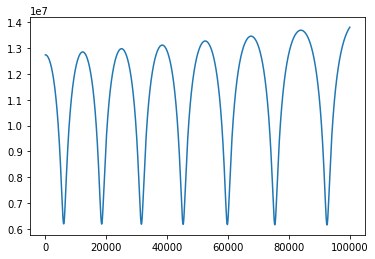

In [223]:
plt.plot(r_arr)

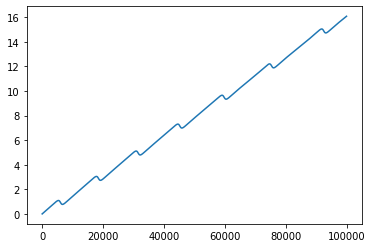

In [224]:
plt.plot(phi_arr)

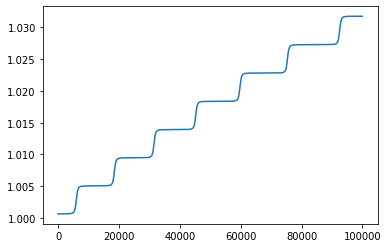

In [225]:
plt.plot((gamma_arr) / gamma0)

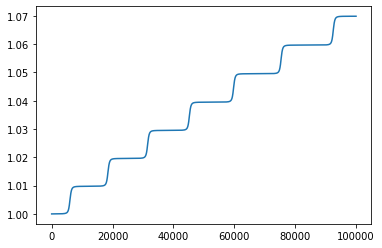

In [226]:
# momentum magnitude
# p_arr = np.sqrt(np.array(trajectory_dict["pr"])**2. + np.array(r_arr * trajectory_dict["ptheta"])**2. + np.array(r_arr * np.sin(theta_arr) * trajectory_dict["pphi"])**2.)
p_arr = pr_arr**2. + ptheta_arr**2. + (pphi_arr)**2.
plt.plot(p_arr / momentum**2.)
# plt.plot(trajectory_dict["p"])

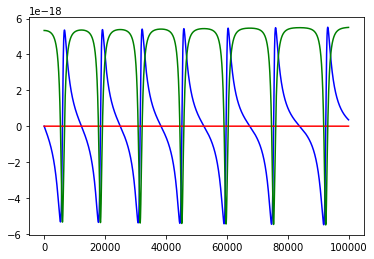

In [228]:
plt.plot(pr_arr, color="b")
plt.plot(ptheta_arr, color="r")
plt.plot(pphi_arr, color="g")

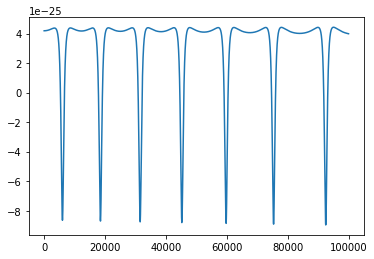

In [229]:
plt.plot(pphi_arr / (r_arr * np.sin(theta_arr)))

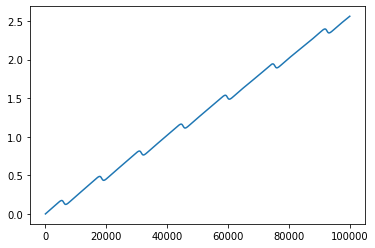

In [230]:
# number of turns
plt.plot(np.array(trajectory_dict["phi"]) / (2.* np.pi))

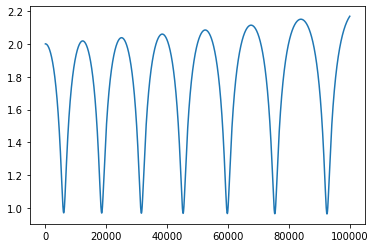

In [231]:
# r value
plt.plot(np.array(trajectory_dict["r"]) / EARTH_RADIUS)

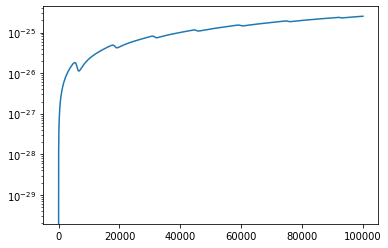

In [232]:
# phi component of ang momentum
# this should be zero (no ptheta component for larmor radius)
plt.semilogy(ptheta_arr * r_arr)

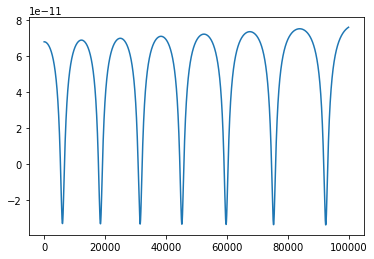

In [235]:
# theta component of ang momentum
plt.plot(pphi_arr * r_arr)

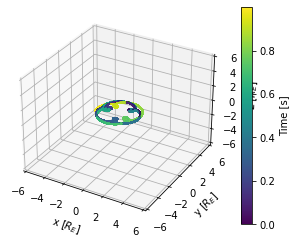

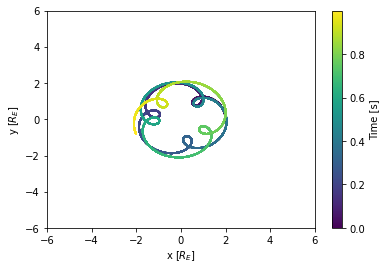

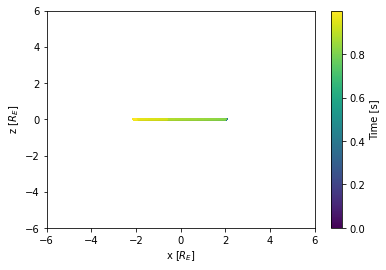

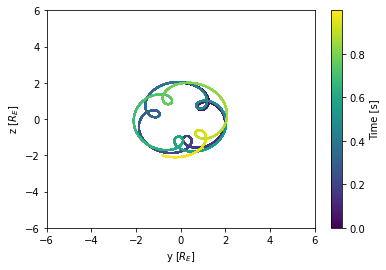

In [234]:
 # convert spherical coordinate trajectory arrays back to cartesian for plotting
(trajectory_t, trajectory_x, trajectory_y,
 trajectory_z) = get_trajectory_cartesian(trajectory_dict)

# print(trajectory_x, trajectory_y, trajectory_z)

# plot the 3d plot and the projections onto each plane as well
plot_trajectories(trajectory_t, trajectory_x, trajectory_y, trajectory_z)

In [83]:
q = 1.602e-19
# Bz = 2.91e-5
m = 1.67e-27

In [146]:
def Bz(r):
#     return (-2.91e-5) * (EARTH_RADIUS / r)**3.
    return -2.91e-5

In [147]:
def dvxdt(r, vx, vy):
    return q*(vy*Bz(r))

def dvydt(r, vx, vy):
    return -q*(vx*Bz(r))


In [152]:
def dvphidt(r, vphi):
#     print(Bz(r))
    return q*vphi*Bz(r)

In [153]:
# r = 96721.88115371251
r = 2. * EARTH_RADIUS
phi = 0.
vr = 0.
vphi = 0.9*(3e8)
dt = 1e-10

In [154]:
# larmor_radius = (m*vphi) / (q*Bz(r))
# print(larmor_radius)

In [155]:
r_arr = []
phi_arr = []
for i in range(100000):
    r += dt * vr
    phi += dt * vphi
    vphi += dt * dvphidt(vphi, r)
    
    r_arr.append(r)
    phi_arr.append(phi)
    
# print(r_arr, phi_arr)

In [156]:
x_arr = r_arr * np.cos(phi_arr)
y_arr = r_arr * np.sin(phi_arr)

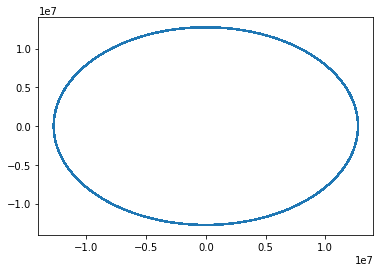

In [157]:
plt.plot(x_arr, y_arr)

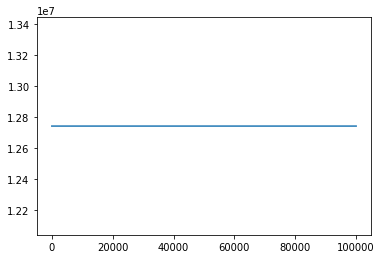

In [158]:
plt.plot(np.sqrt(x_arr**2. + y_arr**2.))

In [165]:
x = 0.
y = 2. * EARTH_RADIUS
z = 0.
vx = 10.
vy = 10.
vz = 0.
dt = 0.0001

In [166]:
# larmor_radius = (m*np.sqrt(vx**2. + vy**2.)) / (q*Bz(np.sqrt(x**2. + y**2.)))
# print(larmor_radius)

In [167]:
x_arr = []
y_arr = []
z_arr = []
vx_arr = []
vy_arr = []
vz_arr = []

In [170]:
for i in range(1000):
    r = np.sqrt(x**2. + y**2.)
    x += dt * vx
    y += dt * vy
    vx += dt * dvxdt(r, vx, vy)
    vy += dt * dvydt(r, vx, vy)
#     t += dt
    
#     print(np.sqrt(vx**2. + vy**2.))
    
    x_arr.append(x)
    y_arr.append(y)
    vx_arr.append(vx)
    vy_arr.append(vy)
    

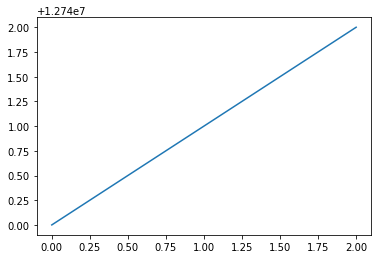

In [171]:
plt.plot(x_arr, y_arr)

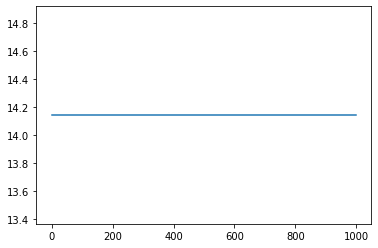

In [172]:
plt.plot(np.sqrt(np.array(vx_arr)**2. + np.array(vy_arr)**2.))